This variation of the dr olsen preprocessing is slightly modified to work with the 2 class merge version of the training data. It then cleans the 2 class version of the training data. Need to double check if this was before or after the downsampling.

Creating another variation on the initial data

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Train data needs params Data_Raw, train_data, X_train_2c_downsamp, y_train_2c_downsamp
# Test data needs params Data_Raw, test_data, X_test_2c_downsamp, y_test_2c_downsamp
def data_input(folder1, folder2, file_x, file_y):
    X = pd.read_csv(f"../{folder1}/{folder2}/{file_x}.csv")
    y = pd.read_csv(f"../{folder1}/{folder2}/{file_y}.csv")
    df = pd.concat([X, y], axis=1)
    return df


In [3]:
# TEST SET INPUT
df = data_input("Data_Raw", "train_data", "X_train_2c_downsamp", "y_train_2c_downsamp")
df.head()

,ID,Source,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Severity
0,A-572015,Source2,2022-07-08 08:30:26,2022-07-08 09:00:05,39.223404,-76.805908,NaN,NaN,0.000,Crash on MD-100 Eastbound at Exit 2 MD-108.,...,False,False,False,False,False,Day,Day,Day,Day,0
1,A-4521402,Source1,2023-01-19 14:09:43.000000000,2023-01-19 15:24:43.000000000,38.672599,-76.876190,38.671519,-76.876250,0.075,Incident on CRAIN HWY near CRAIN HWY Drive wit...,...,False,False,False,False,False,Day,Day,Day,Day,0
2,A-5988633,Source1,2021-06-30 16:25:51,2021-06-30 18:06:33,39.345120,-76.509486,39.322850,-76.530146,1.894,I-95 SOUTH PRIOR TO EXIT 62 I 895 HARBOR TUNNE...,...,False,False,False,False,False,Day,Day,Day,Day,0
3,A-7576332,Source1,2018-06-28 09:32:30,2018-06-28 15:32:30,39.353038,-77.015670,39.336680,-77.013648,1.135,Closed at Mt Airy - Road closed due to accident.,...,False,True,False,False,False,Day,Day,Day,Day,1
4,A-3054320,Source2,2018-01-09 19:04:26,2018-01-09 19:33:45,39.110779,-77.187241,NaN,NaN,0.000,Lane blocked and right hand shoulder blocked d...,...,False,False,False,False,False,Night,Night,Night,Night,1


In [4]:
# TRAIN SET INPUT
#df = data_input("Data_Raw", "train_data", "X_train_2c_downsamp", "y_train_2c_downsamp")
#df.head()

## Drop columns unlikely to be useful

Too focused on timing or too fine grained or unique

In [5]:
df.columns

Index(['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City',
       'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Severity'],
      dtype='object')

In [6]:
df.drop(["ID","Source","Country"],axis=1,inplace=True) # drop clearly unneeded columns

In [7]:
df["Zipcode"] = df.Zipcode.apply(lambda x: str(x).split("-")[0]) # fix zipcodes so that they are all 5 digit

In [8]:
df.drop(["End_Time","End_Lat","End_Lng"],axis=1,inplace=True) #can't know these things before it happens

In [9]:
df.drop(["Start_Lat","Start_Lng","State","City"],axis=1,inplace=True)# so much of location data is redundant and correlated

In [10]:
df.drop(["Timezone","Weather_Timestamp","Airport_Code","Description"],axis=1,inplace=True)

In [11]:
df.drop(["Start_Time","Zipcode","County"],axis=1,inplace=True)

## Street Type

In [12]:
df = df[~df.Street.str.contains("Francis Scott Key Bridge",na=False)|~df.Street.str.contains("Alexandria - Gaylord",na=False)]

In [13]:
print(df.Street.value_counts().shape)
df.Street.value_counts()

(4449,)


Street
I-95 S               2661
I-95 N               2659
Capital Beltway S    1798
Capital Beltway N    1356
I-695 E              1332
                     ... 
 Bay Dale Dr            1
Mason Springs Rd        1
 Potee St               1
S Waterford Rd          1
 Henderson Ave          1
Name: count, Length: 4449, dtype: int64

In [14]:
def nsew(x,r):
    if x[-1] in ["N","S","E","W"]:
        r= r+x[-1]
    return r

In [15]:
def street_type(x):
    if "Tunl" in x or "Tunnel" in x:
        return "Tunnel"#nsew(x,"Tunnel")
    if "I-" in x or "I " in x:
        return "Interstate"
    if " Dr " in x or " Ave " in x or " Rd " in x or " Xing" in x or " Way " in x:
        return "local"
    if "Beltway" in x:
        return "Beltway"
    if "US-" in x[:4] or "US " in x or "MD-" in x[:4] or "Expy" in x:
        return "Highway"
    if "Hwy" in x or "Fwy" in x or "Highway" in x or "Route" in x or "Connector" in x or "Byp" in x \
        or "Bypass" in x or "Gtwy" in x or "Brg" in x or "Trwy" in x or "Rt" in x or "Conn" in x or "Exp" in x \
        or "Thwy" in x:
        return "Highway"
    if x[-2:] in ["St","Pl","Dr","Sq"]:
        return "local"
    if "Ln" in x or "Rd" in x or "Ct" in x:
        return "local"
    if x[-3:] in ["Way","Cir","Ter","Trl","Plz","Aly","Grn","way","Ext"]:
        return "local"
    if x[-3:] in ["-A", "-B", "-11", "-33"]:
        return "on_off_ramp"
    if x[-1] in ["A", "B", "C"]:
        return "on_off_ramp"
    if "Ave" in x[-5:] or " Blvd" in x or " Pike" in x or "Pkwy" in x or "Crse" in x or "Alameda" in x:
        return "large_local"
    if "Garth" in x or "Spell" in x or "Psge" in x or "Chase" in x or "Cutoff" in x or "Spire" in x:
        return "local"
    if "Overlook" in x or "Battlefield" in x or "Cemetery" in x or "Park" in x or "Base" in x or "Concourse" in x \
        or "Memorial" in x or "Booth's" in x or "Bywy" in x or "Underground" in x:
        return "special"
    if "Loop" in x or "Greenway" in x or "West" in x or "ville" in x or "wood" in x:
        return "local"
    if "St" in x or "Mnr" in x or "Pass" in x or "Run" in x or "Mall" in x or "Row" in x or "Grv":
        return "local"
    return x

In [16]:
df["Street"] = df["Street"].astype(str)
df["Street"] = df.Street.apply(street_type)

In [17]:
df=df.loc[~df.Street.str.contains("special")]


In [18]:
df.Street.value_counts()
# added Intercounty conn as highway
# added rt 100 as highway
# added ocean city exp as highway
# byway as special
# added on_off_ramp
# aberdeen thwy as highway
# east c st 2 as local
# prettyman manor is trailer park, made local
# alexandria-gaylord is bridge, remove
# Urbana Church Pass is local
# olde mill run as local
# harriet tubman byway as special
# poncabird pass as local
# Thompson creek mall as local

Street
Interstate     17541
local          13833
Highway         9929
large_local     9778
Beltway         5970
Tunnel           920
on_off_ramp      144
Name: count, dtype: int64

## Weather Condition

In [19]:
df["Weather_Condition"].value_counts()

Weather_Condition
Fair                    13869
Cloudy                   6523
Mostly Cloudy            6257
Clear                    5046
Partly Cloudy            4010
                        ...  
T-Storm / Windy             1
Thunder / Windy             1
Heavy Drizzle               1
Blowing Snow / Windy        1
Heavy Ice Pellets           1
Name: count, Length: 66, dtype: int64

In [20]:
df = df.loc[(df.Weather_Condition != "Sand")] # too few values

In [21]:
# missing values count as a float
# change to "unknown" instead. Later we can decide if we want to keep
df["Weather_Condition"] = df["Weather_Condition"].fillna("unknown")

In [22]:
df["Weather_Condition"] = df["Weather_Condition"].apply(lambda x: "None" if "N/A" in x else x)

In [23]:
df["Weather_Condition"]=df["Weather_Condition"].apply(lambda x: "Windy" if "Windy" in x else x)

In [24]:
def mapping_1(x):
    tomap = {"Light Drizzle":"Drizzle",
            "Light Rain with Thunder":"Light Thunderstorms and Rain",
            "Thunder in the Vicinity":"Thunder",
            "Heavy Drizzle":"Rain",
            "Mist":"Fog",
            "Light Freezing Drizzle":"Light Freezing Rain"}
    if x in tomap:
        return tomap[x]
    return x

In [25]:
def mapping_2(x):
    tomap = {"Light Rain Shower":"Drizzle",
             "Light Rain":"Drizzle",
            "Light Ice Pellets":"Ice Pellets",
            "Shallow Fog":"Fog"}
    if x in tomap:
        return tomap[x]
    return x

In [26]:
def mapping_3(x):
    tomap = {"Heavy Ice Pellets":"Ice Pellets",
            "Drizzle and Fog":"Fog",
            "Patches of Fog":"Fog",
            "Heavy Snow":"Snow",
            "Heavy Thunderstorms and Rain":"Thunderstorms",
            "T-Storm":"Thunderstorms",
            "Heavy T-Storm":"Thunderstorms",
            "Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [27]:
def mapping_4(x):
    tomap = {"Light Snow Shower":"Snow",
            "Light Snow":"Snow",
            "Light Rain Showers":"Drizzle",
            "Light Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [28]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_1)                        

In [29]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_2)

In [30]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_3)

In [31]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_4)

In [32]:
df.Weather_Condition.value_counts()

Weather_Condition
Fair                    13869
unknown                 11976
Cloudy                   6523
Mostly Cloudy            6257
Clear                    5046
Partly Cloudy            4010
Overcast                 3291
Drizzle                  2289
Scattered Clouds         1776
Snow                      721
Fog                       615
Rain                      529
Windy                     382
Haze                      159
Heavy Rain                149
Wintry Mix                146
Thunderstorms             142
Thunder                    66
Light Freezing Rain        58
Ice Pellets                24
Snow and Sleet             22
Thunderstorm               17
Small Hail                 10
Light Sleet                 8
None                        7
Light Snow and Sleet        5
Hail                        5
Light Freezing Fog          4
Sleet                       3
Heavy Sleet                 2
Freezing Rain               2
Name: count, dtype: int64

None and Light Sleet have almost no rows will values, drop them.
Light Freezing Fog has 10 rows. Change to Fog.
Leave others for now. Will need to decide if further combinations are necessary.

In [33]:
df = df.loc[(df.Weather_Condition != "None") & (df.Weather_Condition != "Light Sleet")]

In [34]:
df=df.reset_index(drop=True)

In [35]:
df.shape

(58098, 29)

## Wind Direction

In [36]:
# Can decide later whether to keep or remove rows with unknown values
df["Wind_Direction"] = df.Wind_Direction.fillna("unknown")

In [37]:
df.Wind_Direction.value_counts()

Wind_Direction
CALM        8111
unknown     7909
North       4669
Calm        4175
WNW         3406
NW          3094
W           2233
S           2191
NNW         2169
SSW         2007
SW          1796
SSE         1687
N           1630
SE          1550
NNE         1487
WSW         1454
NE          1283
ENE         1222
West        1160
ESE         1067
E           1057
South        947
VAR          824
East         562
Variable     408
Name: count, dtype: int64

In [38]:
# Basic cleanup of alternative spellings
def wind_map(x):
    tomap = {"CALM":"Calm","South":"S","West":"W","North":"N","East":"E","VAR":"Variable"}
    if x in tomap:
        return tomap[x]
    return x

In [39]:
# Less fine grained values
def wind_2(x):
    tomap = {"WNW":"NW","NNW":"NW","SSW":"SW","SSE":"SE","WSW":"SW","NNE":"NE","ENE":"NE","ESE":"SE"}
    if x in tomap:
        return tomap[x]
    return x

In [40]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_map)

In [41]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_2)

In [42]:
df.Wind_Direction.value_counts()

Wind_Direction
Calm        12286
NW           8669
unknown      7909
N            6299
SW           5257
SE           4304
NE           3992
W            3393
S            3138
E            1619
Variable     1232
Name: count, dtype: int64

## Missing Values: drop columns

In [43]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Severity'],
      dtype='object')

In [44]:
df.shape

(58098, 29)

In [45]:
df.isna().sum()

Distance(mi)                 0
Street                       0
Temperature(F)            6128
Wind_Chill(F)            23368
Humidity(%)               6173
Pressure(in)              5649
Visibility(mi)           12142
Wind_Direction               0
Wind_Speed(mph)          16115
Precipitation(in)        24411
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset             110
Civil_Twilight             110
Nautical_Twilight          110
Astronomical_Twilight      110
Severity                     0
dtype: int64

In [46]:
# half of the rows are missing wind chill. Better to just drop the column
df.drop(["Wind_Chill(F)"],axis=1,inplace=True)

In [47]:
# half of the rows are missing precipitation, and weather condition already
# covers that situation more or less. So drop
df.drop(["Precipitation(in)"],axis=1,inplace=True)

<Axes: >

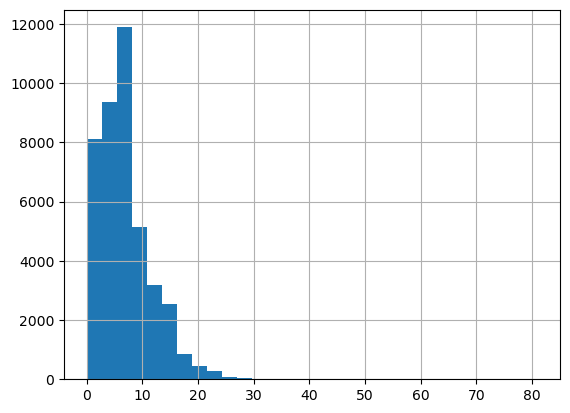

In [48]:
df["Wind_Speed(mph)"].hist(bins=30)

In [49]:
df[df["Wind_Speed(mph)"] > 40].shape[0]

4

Wind speed has a significant number of missing values. It is also a fairly tight distribution other than 11 values that are larger. Although wind speed could be useful in predicting severity, it may not be worth keeping in this situation. I think we try without it first.

In [50]:
df.drop(["Wind_Speed(mph)"],inplace=True,axis=1)

In [51]:
df.isna().sum()

Distance(mi)                 0
Street                       0
Temperature(F)            6128
Humidity(%)               6173
Pressure(in)              5649
Visibility(mi)           12142
Wind_Direction               0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset             110
Civil_Twilight             110
Nautical_Twilight          110
Astronomical_Twilight      110
Severity                     0
dtype: int64

In [52]:
df.dropna().shape

(45329, 26)

It looks like dropping NA values doesn't remove too many rows, there must be rows with multiple NA values. So let's drop NA rows.

In [53]:
df.dropna(inplace=True)

## Twilights

We don't need four different twilights.

In [54]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Severity'],
      dtype='object')

In [55]:
df.drop(['Civil_Twilight','Nautical_Twilight', 'Astronomical_Twilight'],inplace=True,axis=1)

## Any columns have too little info?

In [56]:
for col in ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop']:
    print(df[col].value_counts())

Amenity
False    45113
True       216
Name: count, dtype: int64
Bump
False    45323
True         6
Name: count, dtype: int64
Crossing
False    43036
True      2293
Name: count, dtype: int64
Give_Way
False    45235
True        94
Name: count, dtype: int64
Junction
False    39282
True      6047
Name: count, dtype: int64
No_Exit
False    45274
True        55
Name: count, dtype: int64
Railway
False    45261
True        68
Name: count, dtype: int64
Roundabout
False    45327
True         2
Name: count, dtype: int64
Station
False    44937
True       392
Name: count, dtype: int64
Stop
False    44821
True       508
Name: count, dtype: int64
Traffic_Calming
False    45208
True       121
Name: count, dtype: int64
Traffic_Signal
False    40634
True      4695
Name: count, dtype: int64
Turning_Loop
False    45329
Name: count, dtype: int64


Bump, Give_Way, No_Exit, Roundabout, have almost no True values, so drop.
All values in Turning_Loop are identical, so drop.

In [57]:
df.drop(['Bump', 'Give_Way', 'No_Exit', 'Roundabout','Turning_Loop'],inplace=True,axis=1)

Will need to consider if it is worth keeping all of these or combining in some way.

In [58]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Severity'],
      dtype='object')

In [59]:
df.shape

(45329, 18)

In [60]:
df.head(50)

,Distance(mi),Street,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Severity
0,0.000,Highway,75.0,82.0,29.88,10.0,Variable,Mostly Cloudy,False,False,False,False,False,False,False,False,Day,0
1,0.075,Highway,45.0,89.0,29.44,10.0,Calm,Drizzle,False,False,False,False,False,False,False,False,Day,0
2,1.894,Interstate,91.0,66.0,29.95,10.0,SE,Partly Cloudy,False,False,False,False,False,False,False,False,Day,0
3,1.135,local,80.1,71.0,29.91,10.0,NW,Partly Cloudy,False,True,False,True,False,True,False,False,Day,1
4,0.000,Interstate,37.0,62.0,30.40,10.0,Calm,Clear,False,False,False,False,False,False,False,False,Night,1
5,0.000,Highway,32.0,69.0,29.66,10.0,NW,Partly Cloudy,False,False,False,False,False,False,False,False,Night,1
6,0.323,local,81.0,39.0,29.66,10.0,NW,Mostly Cloudy,False,False,False,False,False,False,False,False,Day,1
7,0.000,large_local,85.5,66.0,30.12,10.0,SW,Clear,False,False,True,False,False,False,False,False,Day,1
9,0.000,Interstate,61.0,41.0,29.88,10.0,NW,Mostly Cloudy,False,False,False,False,False,False,False,False,Day,1
13,0.628,Interstate,57.0,81.0,29.55,10.0,Variable,Cloudy,False,False,False,False,False,False,False,False,Day,0


In [61]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Severity'],
      dtype='object')

In [62]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(45329, 18)
(40340, 18)


In [63]:
df.head()

,Distance(mi),Street,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Weather_Condition,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Severity
0,0.000,Highway,75.0,82.0,29.88,10.0,Variable,Mostly Cloudy,False,False,False,False,False,False,False,False,Day,0
1,0.075,Highway,45.0,89.0,29.44,10.0,Calm,Drizzle,False,False,False,False,False,False,False,False,Day,0
2,1.894,Interstate,91.0,66.0,29.95,10.0,SE,Partly Cloudy,False,False,False,False,False,False,False,False,Day,0
3,1.135,local,80.1,71.0,29.91,10.0,NW,Partly Cloudy,False,True,False,True,False,True,False,False,Day,1
4,0.000,Interstate,37.0,62.0,30.40,10.0,Calm,Clear,False,False,False,False,False,False,False,False,Night,1


In [64]:
df.columns

Index(['Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Severity'],
      dtype='object')

In [67]:
# Train data needs Data_Cleaned, train_data, X_train_control, y_train_control
# Test data needs Data_Cleaned, test_data, X_test_control, y_test_control
col_class = ['Class']
col_data = ['Street', 'Temperature(F)', 'Humidity(%)',
            'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
            'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
            'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset']

df = df.rename(columns={'Severity' : 'Class'})
df = df.drop_duplicates()

X = df.iloc[:,:-1]
y = df.Class

# TRAINING
X.to_csv('../Data_Cleaned/train_data/control_2class_X_train.csv', columns = col_data, index = False)
y.to_csv('../Data_Cleaned/train_data/control_2class_y_train.csv', columns = col_class, index = False)

# TESTING
#X.to_csv('../Data_Cleaned/test_data/control_2class_X_test.csv', columns = col_data, index = False)
#y.to_csv('../Data_Cleaned/test_data/control_2class_y_test.csv', columns = col_class, index = False)

In [66]:
# TRAIN OUTPUT
